In [1]:
import torch
import torchvision
import torchvision.transforms as T
from torchvision import datasets, models
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
data_transforms = T.Compose([T.Resize(256),
                            T.CenterCrop(224),
                            T.ToTensor(),
                            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

image_datasets = datasets.ImageFolder('../input/garbage-classification/garbage_classification', data_transforms)
print(len(image_datasets))

class_names = image_datasets.classes
print(class_names)

15515
['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [3]:
datasets = {}
train_idx, test_idx = train_test_split(list(range(len(image_datasets))), test_size=0.2)
datasets['test'] = torch.utils.data.Subset(image_datasets, test_idx)
train_set = torch.utils.data.Subset(image_datasets, train_idx)
train_idx, val_idx = train_test_split(list(range(len(train_set))), test_size=0.25)
datasets['val'] = torch.utils.data.Subset(image_datasets, val_idx)
datasets['train'] = torch.utils.data.Subset(image_datasets, train_idx)
print(len(datasets['train']), len(datasets['val']), len(datasets['test']))

9309 3103 3103


In [4]:
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], 32, shuffle=True) for x in ['train','val','test']}
x, y = next(iter(dataloaders['train']))
print(x.shape, y.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])


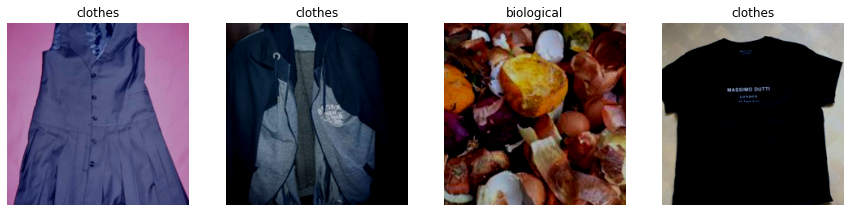

In [5]:
images, labels = next(iter(dataloaders['train']))
plt.figure(figsize=(15,15))
for i in range(4):
    plt.subplot(1, 4, i+1)
    imgs = images[i].numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    imgs = std * imgs + std
    imgs = np.clip(imgs, 0, 1)
    plt.imshow(imgs)
    plt.axis('off')
    plt.title(class_names[labels[i]])

In [9]:
def train_model(model, criterion, optimizer, lr_scheduler, epochs=20):
    train_start = time.time()
    history = []
    best_acc = 0.0
    
    for epoch in range(epochs):
        epoch_start = time.time()
        train_loss, train_acc, val_loss, val_acc = 0.0, 0.0, 0.0, 0.0        
        
        model.train()
        for (inputs, labels) in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            
            _, preds = torch.max(outputs, 1)
            train_acc += torch.sum(preds == labels.data)
            
        lr_scheduler.step()
            
        with torch.no_grad():
            model.eval()
            
            for (inputs, labels) in dataloaders['val']:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                
                _, preds = torch.max(outputs, 1)
                val_acc += torch.sum(preds == labels.data)
        
        train_loss /= len(datasets['train'])
        train_acc /= len(datasets['train'])
        val_loss /= len(datasets['val'])
        val_acc /=  len(datasets['val'])
        history.append([train_loss, train_acc, val_loss, val_acc])
        
        print("Epoch : {}, train_loss: {:.4f}, train_acc: {:.4f}, val_loss : {:.4f}, val_acc: {:.4f}, Time: {:.4f}s".format(epoch+1, train_loss, train_acc, val_loss, val_acc, time.time()-epoch_start))
    return model, history

In [7]:
alexnet = models.alexnet(pretrained=True)
for param in alexnet.parameters():
    param.requires_grad = False
    
num_features = alexnet.classifier[6].in_features
alexnet.classifier[6] = torch.nn.Linear(num_features, len(class_names))
alexnet = alexnet.to(device)

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(alexnet.parameters())
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [10]:
trained_model, history = train_model(alexnet, loss_func, optimizer, lr_scheduler, epochs=30)

Epoch : 1, train_loss: 0.1536, train_acc: 0.9487, val_loss : 0.2885, val_acc: 0.9220, Time: 64.0876s
Epoch : 2, train_loss: 0.1055, train_acc: 0.9646, val_loss : 0.2846, val_acc: 0.9294, Time: 63.3598s
Epoch : 3, train_loss: 0.0866, train_acc: 0.9693, val_loss : 0.2948, val_acc: 0.9262, Time: 62.7479s
Epoch : 4, train_loss: 0.0806, train_acc: 0.9713, val_loss : 0.3015, val_acc: 0.9330, Time: 62.6428s
Epoch : 5, train_loss: 0.0505, train_acc: 0.9824, val_loss : 0.2755, val_acc: 0.9381, Time: 63.1541s
Epoch : 6, train_loss: 0.0314, train_acc: 0.9893, val_loss : 0.2714, val_acc: 0.9401, Time: 63.9224s
Epoch : 7, train_loss: 0.0332, train_acc: 0.9889, val_loss : 0.2731, val_acc: 0.9394, Time: 63.4671s
Epoch : 8, train_loss: 0.0265, train_acc: 0.9924, val_loss : 0.2686, val_acc: 0.9397, Time: 63.1855s
Epoch : 9, train_loss: 0.0259, train_acc: 0.9914, val_loss : 0.2659, val_acc: 0.9401, Time: 63.5762s
Epoch : 10, train_loss: 0.0230, train_acc: 0.9938, val_loss : 0.2658, val_acc: 0.9404, Time

In [11]:
train_loss = [h[0] for h in history]
train_acc = [h[1] for h in history]
val_loss = [h[2] for h in history]
val_acc = [h[3] for h in history]

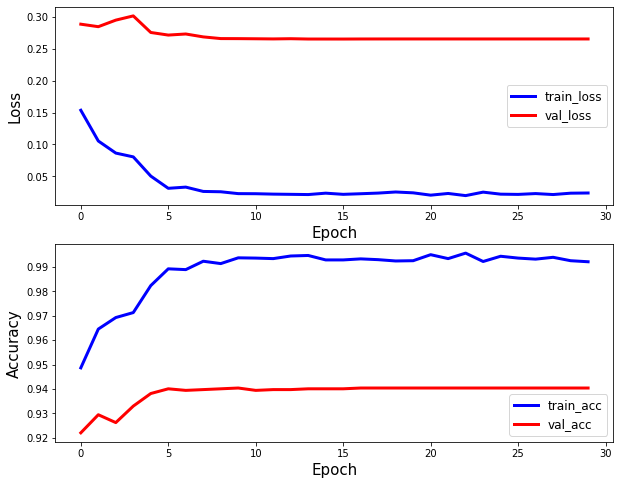

In [12]:
def plot_model_history(history):
    x = np.arange(len(history))
    fig = plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.plot(x, train_loss, label='train_loss', lw=3, c="b")
    plt.plot(x, val_loss, label='val_loss', lw=3, c="r")
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Loss", fontsize=15)

    plt.subplot(2, 1, 2)
    plt.plot(x, train_acc, label='train_acc', lw=3, c="b")
    plt.plot(x, val_acc, label='val_acc', lw=3, c="r")
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Accuracy", fontsize=15)
    plt.show()

plot_model_history(history)

In [13]:
def evaluation_model(model):
    top1 = 0
    top3 = 0
    N = len(datasets['test'])
    for (inputs, labels) in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        outputs = torch.nn.functional.softmax(outputs, dim=-1)
        _, indices = torch.topk(outputs, 3, dim=-1)
        for i in range(len(indices)):
            for j in range(3):
                if indices[i,j] == labels[i]:
                    top3 += 1
                    break
            top1 += 1 if indices[i,0]==labels[i] else 0
    print("Top-1 accuracy: {:.2f}%".format(100*top1/N))
    print("Top-3 accuracy: {:.2f}%".format(100*top3/N))    

In [14]:
evaluation_model(trained_model)

Top-1 accuracy: 86.98%
Top-3 accuracy: 89.62%


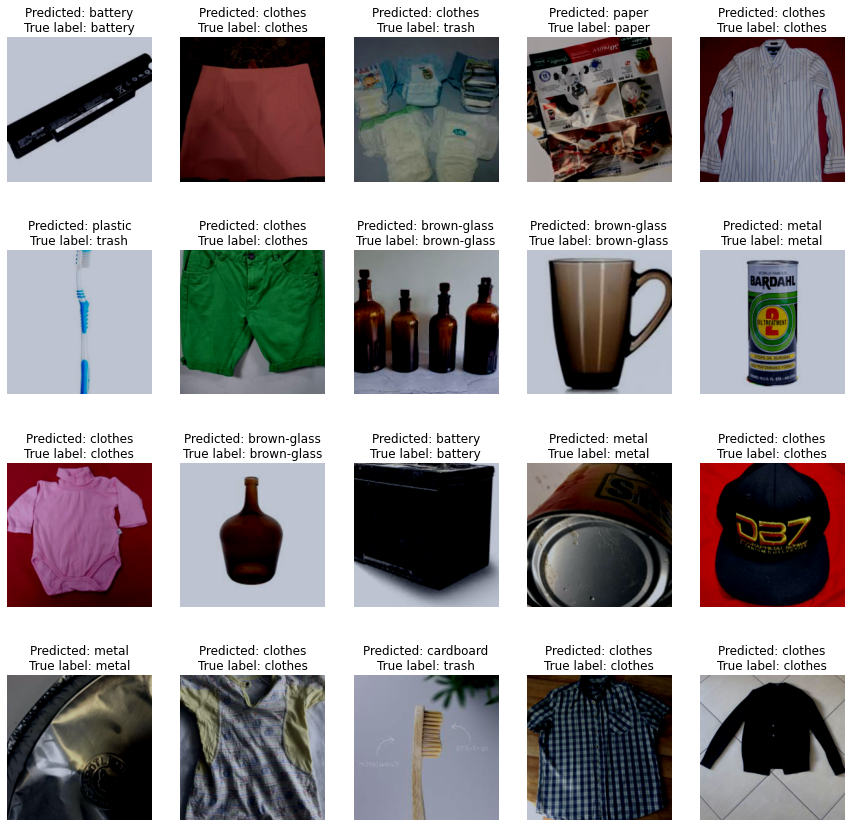

In [17]:
images, labels = next(iter(dataloaders['test']))
images = images.to(device)
outputs = trained_model(images)
_, indices = torch.max(outputs, -1)

plt.figure(figsize=(15,15))
for i in range(20):
    plt.subplot(4, 5, i+1)
    imgs = images[i].cpu().numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    imgs = std * imgs + std
    imgs = np.clip(imgs, 0, 1)
    plt.imshow(imgs)
    plt.axis('off')
    title = f"Predicted: {class_names[indices[i]]}\nTrue label: {class_names[labels[i]]}"
    plt.title(title)

In [ ]:
torch.save(trained_model.state_dict(), 'model.pt')